In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

t = time.time()

# 1. Sentiment140 préprocessée 

In [2]:
def sentiment140(stop_words, lemmatization, negation):
    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    return pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2"))

In [3]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION)
df.head(10)

,sentiment,id,date,query_string,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww that is a bummer you shoulda got david ca...
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can not update his facebook b...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it is not behaving at all i am mad why am i...
5,Negative,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew
6,Negative,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need a hug
7,Negative,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains a bit only a bi...
8,Negative,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope they did not have it
9,Negative,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que me muera


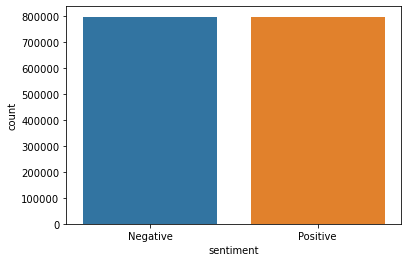

In [4]:
sns.countplot(x='sentiment', data=df)
plt.show()

## 1.1. Fréquence des mots

In [5]:
vectorizer = CountVectorizer(max_features=1000)
vectorizer.fit(df.text)

neg_matrix = vectorizer.transform(df[df.sentiment == 'Negative'].text)
pos_matrix = vectorizer.transform(df[df.sentiment == 'Positive'].text)

In [6]:
print(df[df.sentiment == 'Negative'].iloc[1].text)
print(neg_matrix[1])
liste = vectorizer.get_feature_names()
print([liste[i] for i in neg_matrix[1].tocoo().col])

is upset that he can not update his facebook by texting it and might cry as a result school today also blah
  (0, 25)	1
  (0, 32)	1
  (0, 46)	1
  (0, 119)	1
  (0, 126)	1
  (0, 168)	1
  (0, 249)	1
  (0, 364)	1
  (0, 382)	1
  (0, 425)	1
  (0, 426)	1
  (0, 523)	1
  (0, 578)	1
  (0, 703)	1
  (0, 817)	1
  (0, 847)	1
  (0, 884)	1
  (0, 887)	1
['also', 'and', 'as', 'by', 'can', 'cry', 'facebook', 'he', 'his', 'is', 'it', 'might', 'not', 'school', 'that', 'today', 'update', 'upset']


In [7]:
neg_tf = np.sum(neg_matrix, axis=0)
pos_tf = np.sum(pos_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos],
                            columns=vectorizer.get_feature_names()
                            ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                         ).iloc[:10]

,negative,positive,total
to,344216,272476,616692
the,258047,266160,524207
is,202625,180106,382731
you,129314,232713,362027
not,242055,105213,347268
my,190852,125978,316830
it,157550,147903,305453
and,153963,149641,303604
am,139140,100996,240136
in,115541,101165,216706


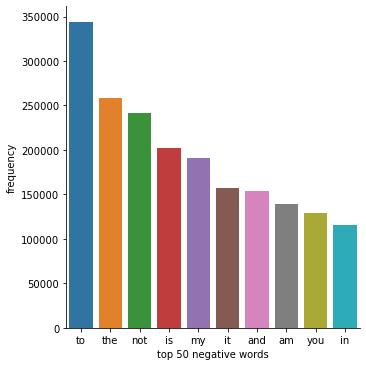

In [8]:
df1 = term_freq_df.sort_values(by='negative', ascending=False).head(10)
g = sns.catplot(x='index', y="negative", kind='bar', data=df1.reset_index())
g.set_axis_labels('top 50 negative words', 'frequency')
plt.show()

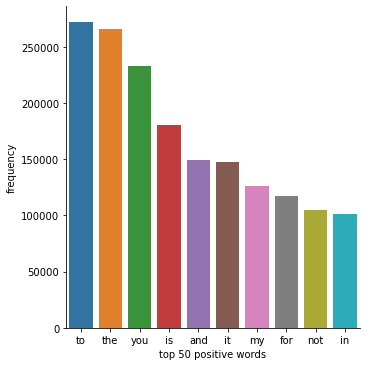

In [9]:
df2 = term_freq_df.sort_values(by='positive', ascending=False).head(10)
g = sns.catplot(x='index', y="positive", kind='bar', data=df2.reset_index())
g.set_axis_labels('top 50 positive words', 'frequency')
plt.show()

In [10]:
def term_frequency(df, column_name, N, rotation=45):
    vectorizer = CountVectorizer(max_features=N)
    vectorizer.fit(df.text)
    
    categories = list(set(df[column_name]))
    catA, catB = categories[0], categories[1]

    A_matrix = vectorizer.transform(df[df[column_name] == catA].text)
    B_matrix = vectorizer.transform(df[df[column_name] == catB].text)
    
    A_tf = np.sum(A_matrix, axis=0)
    B_tf = np.sum(B_matrix, axis=0)
    A = np.squeeze(np.asarray(A_tf))
    B = np.squeeze(np.asarray(B_tf))

    term_freq_df = pd.DataFrame([A, B],
                                columns=vectorizer.get_feature_names()
                                ).transpose()
    term_freq_df.columns = [catA, catB]
    
    nb_mots_A = CountVectorizer().fit_transform(df[df[column_name] == catA].text).sum()
    nb_mots_B = CountVectorizer().fit_transform(df[df[column_name] == catB].text).sum()

#     term_freq_df['total'] = term_freq_df[catA] + term_freq_df[catB]
#     term_freq_df.sort_values(by='total', 
#                              ascending=False
#                             ).iloc[:10]

    term_freq_df[catA] /= nb_mots_A
    term_freq_df[catB] /= nb_mots_B
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    dfA = term_freq_df.sort_values(by=catA, ascending=False).head(N)
    sns.barplot(x='index', y=catA, data=dfA.reset_index(), ax=axes[0])
    axes[0].set(xlabel=f'Top {N} {catA} words', ylabel='frequency')
    axes[0].tick_params('x', labelrotation=rotation)
    
    dfB = term_freq_df.sort_values(by=catB, ascending=False).head(N)
    sns.barplot(x='index', y=catB, data=dfB.reset_index(), ax=axes[1])
    axes[1].set(xlabel=f'Top {N} {catB} words', ylabel='frequency')
    axes[1].tick_params('x', labelrotation=rotation)
    
    ylim_0 = axes[0].get_ylim()[1]
    ylim_1 = axes[1].get_ylim()[1]
    ylim_max = max(ylim_0, ylim_1)
    axes[0].set_ylim((0, ylim_max))
    axes[1].set_ylim((0, ylim_max))

    fig.tight_layout()
    plt.show()


stop_words: False, lemmatization: False, negation: False


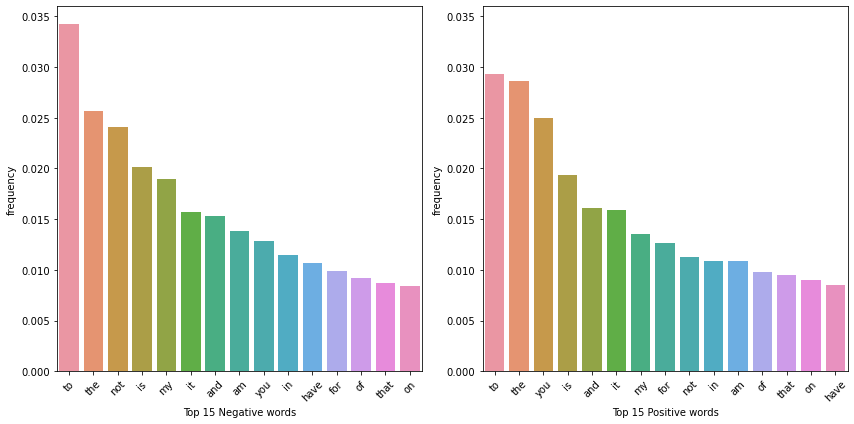


stop_words: False, lemmatization: False, negation: True


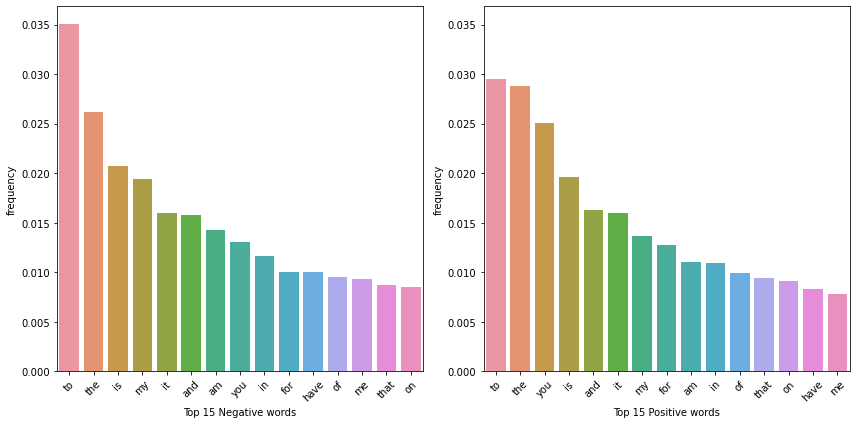


stop_words: False, lemmatization: True, negation: False


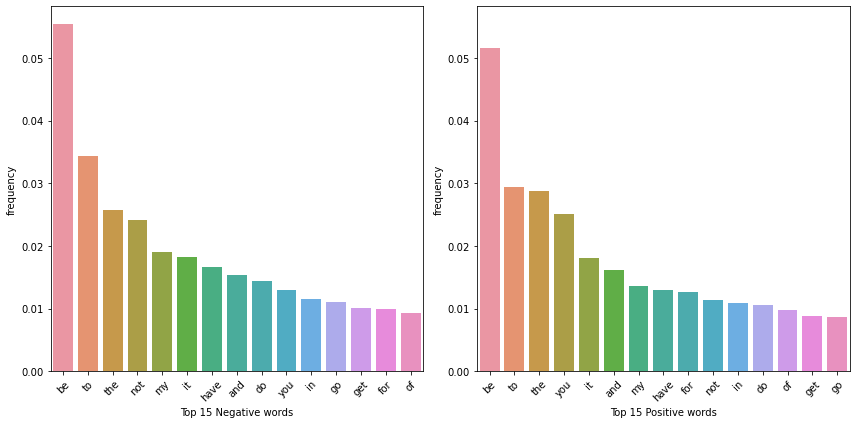


stop_words: False, lemmatization: True, negation: True


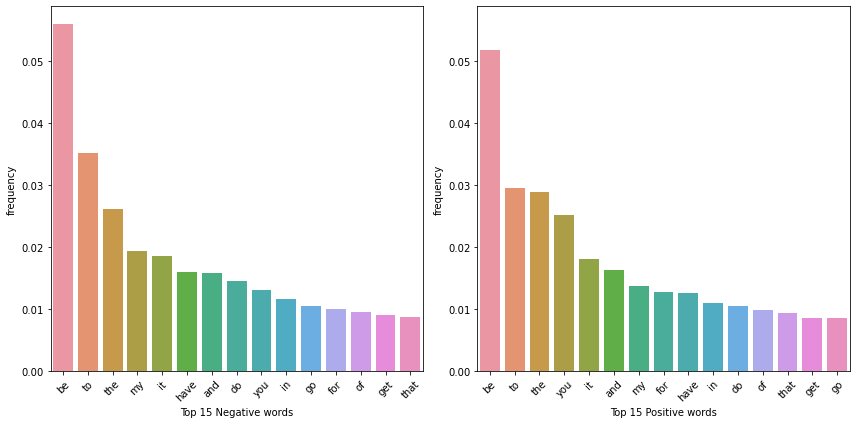


stop_words: True, lemmatization: False, negation: False


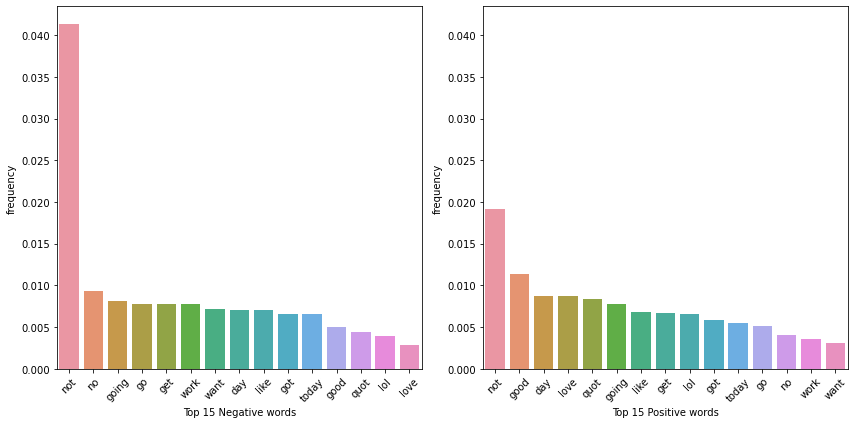


stop_words: True, lemmatization: False, negation: True


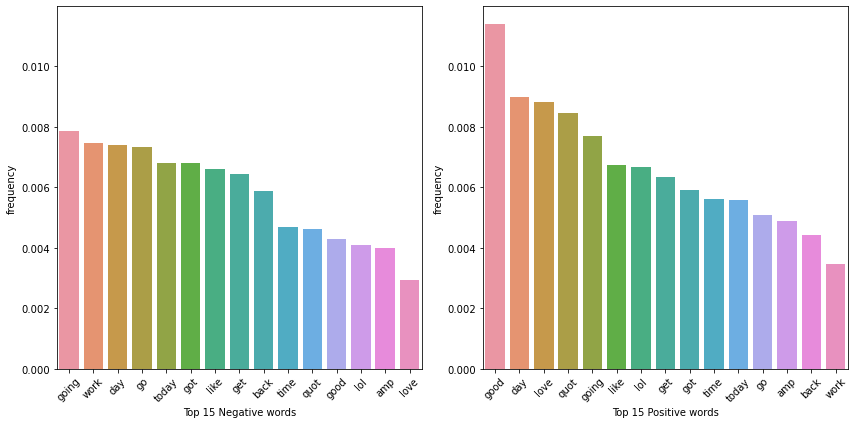


stop_words: True, lemmatization: True, negation: False


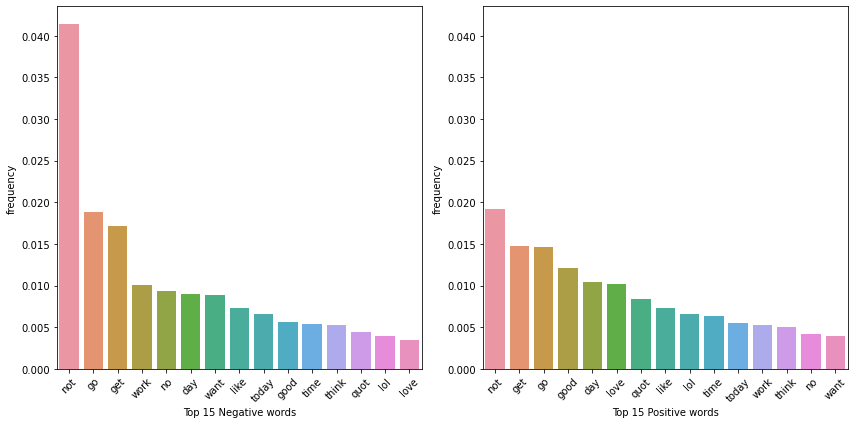


stop_words: True, lemmatization: True, negation: True


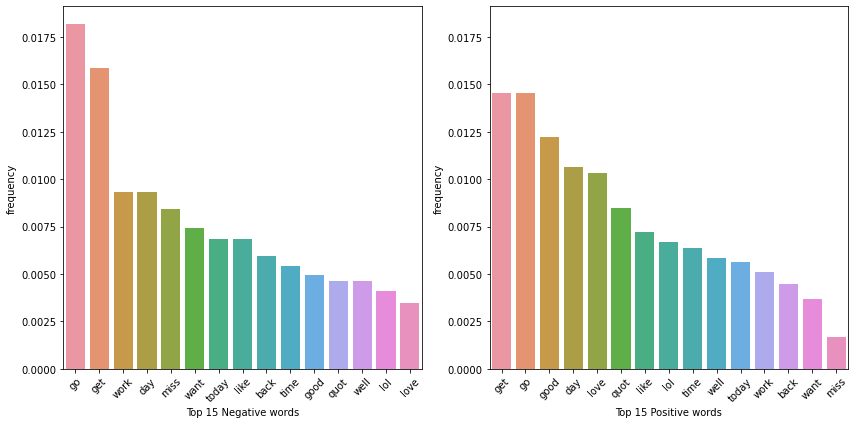

Wall time: 6min 58s


In [11]:
%%time
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            df_temp = sentiment140(stop_words, lemmatization, negation)
            print(f"\nstop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            term_frequency(df_temp, 'sentiment', 15)   

## 1.2. Word cloud

In [12]:
positive_text = " ".join(df[df.sentiment == "Positive"].text.to_numpy().tolist())
negative_text = " ".join(df[df.sentiment == "Negative"].text.to_numpy().tolist())

positive_cloud = WordCloud(stopwords=['get', 'go'], max_words=50, background_color="white").generate(positive_text)
negative_cloud = WordCloud(stopwords=['get', 'go'], max_words=50, background_color="white").generate(negative_text)

In [13]:
def show_word_cloud(cloud, title):
    plt.figure(figsize=(16, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

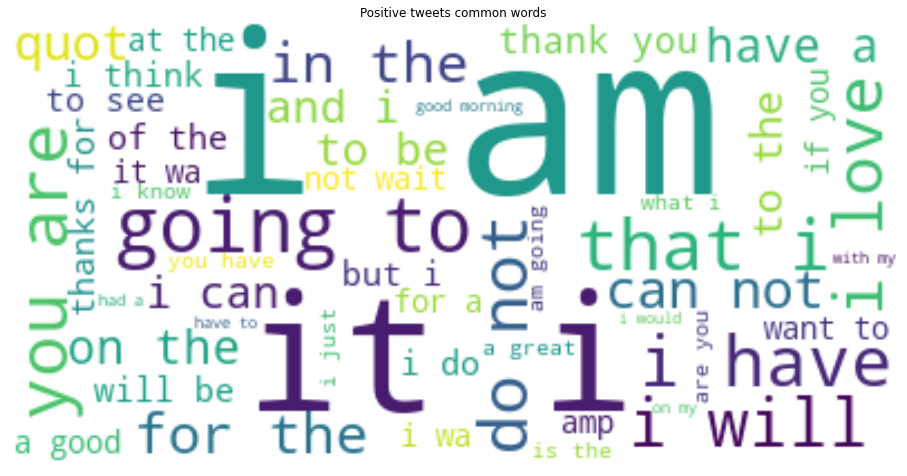

In [14]:
show_word_cloud(positive_cloud, "Positive tweets common words")

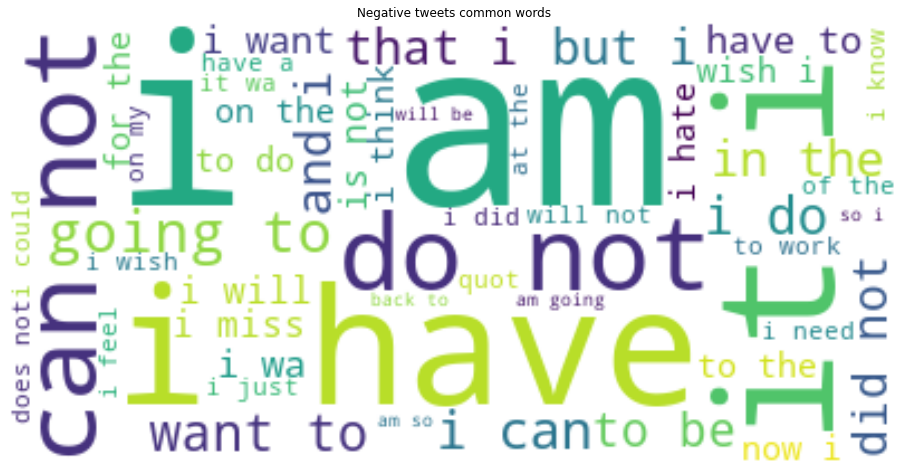

In [15]:
show_word_cloud(negative_cloud, "Negative tweets common words")

## 1.3. Corrélations

In [16]:
STOP_WORDS = True
LEMMATIZATION = True
NEGATION = False
df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION)
df['sentiment_bool'] = (df['sentiment'] == 'Positive').astype(int)
df.head(10)

,sentiment,id,date,query_string,user,text,sentiment_bool
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda get david carr third day,0
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset not update facebook texting might cry re...,0
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive many time ball manage save rest go bound,0
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feel itchy like fire,0
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behave mad not see,0
5,Negative,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not whole crew,0
6,Negative,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug,0
7,Negative,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rain bite bit lol fin...,0
8,Negative,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope not,0
9,Negative,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera,0


In [17]:
def corr_matrix(df, N, vectorizer, first_column=None):
    """
    N : nombre de mots
    """
    vectorizer = vectorizer(max_features=N)
    X = df.text.to_list()
    X = vectorizer.fit_transform(X)
    X = X.toarray().transpose()
    
    features = vectorizer.get_feature_names()
    for i in range(len(features)):
        df[features[i]] = X[i]
        
    plt.figure(figsize=(N / 2, N / 2))
    if first_column:
        columns = [first_column] + list(df.columns[-N:])
    else:
        columns = list(df.columns[-N:])
    sns.set(font_scale=1.5)
    corrMatrix = df[columns].corr()
    corrMatrix = np.abs(corrMatrix)
    sns.heatmap(corrMatrix, cmap="rocket_r", annot=False)
    plt.show()    
    sns.set(font_scale=1)

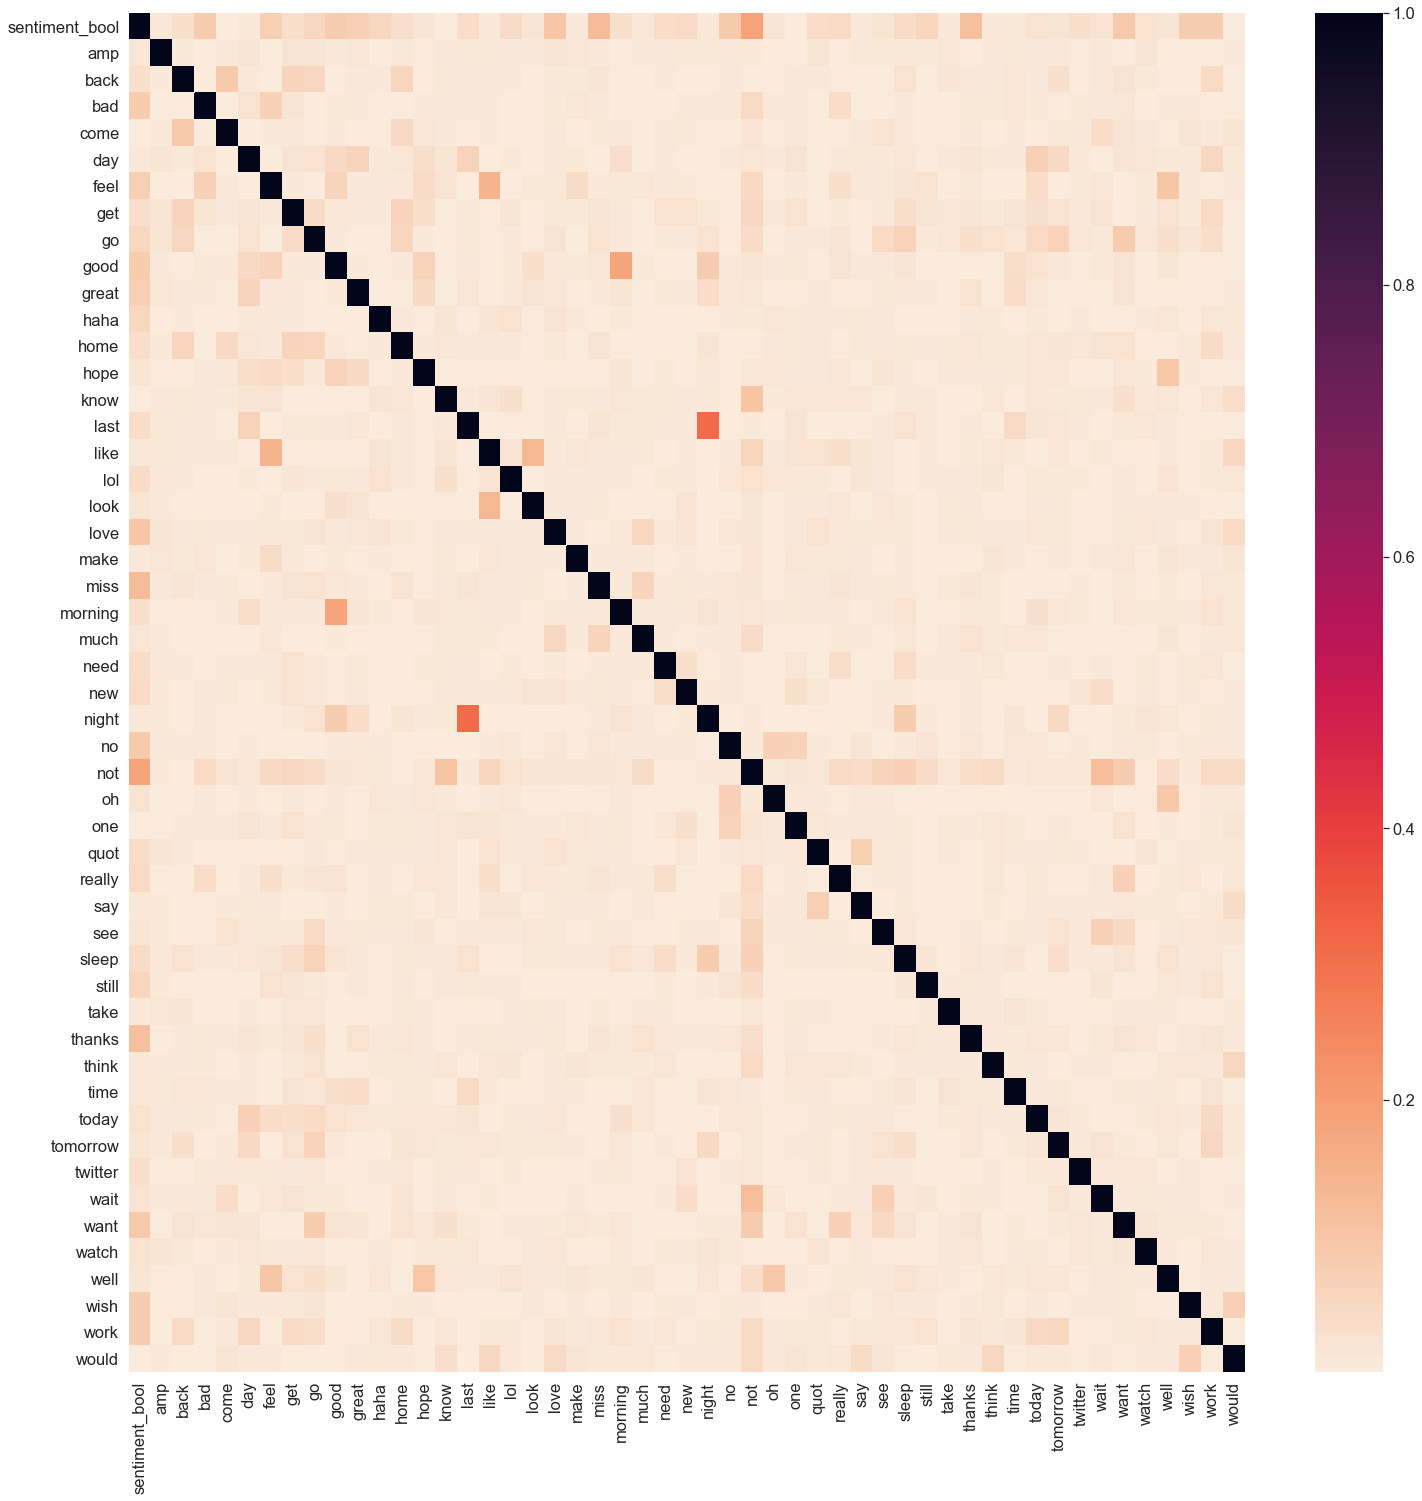

Wall time: 29.1 s


In [18]:
%%time
corr_matrix(df, 50, CountVectorizer, first_column='sentiment_bool')

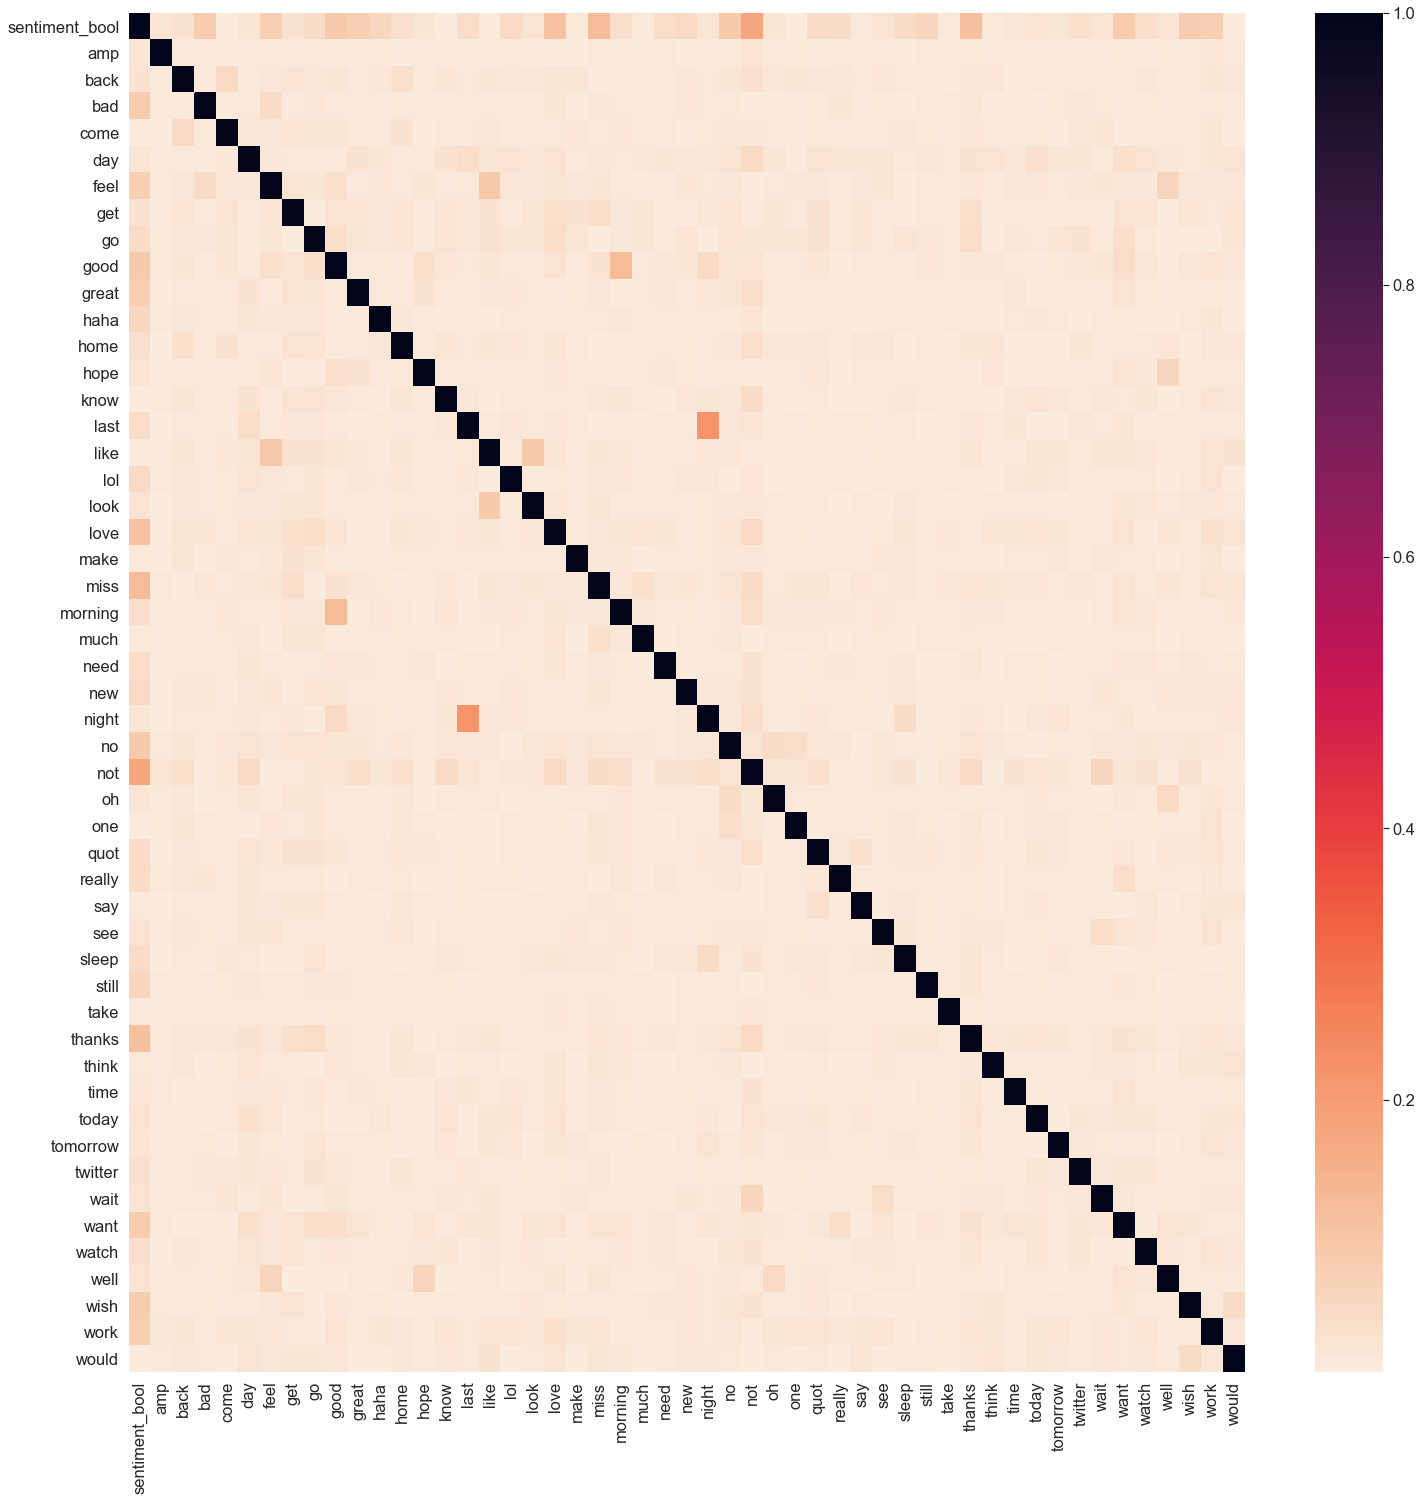

Wall time: 32.3 s


In [19]:
%%time
corr_matrix(df, 50, TfidfVectorizer, first_column='sentiment_bool')

Nous pouvons remarquer une corrélation assez élevée entre certains mots comme `love`, `miss`, `not`, `thanks` et la variable `sentiment_bool`.

# 2. Tweets webscrapés

In [20]:
def tweets_web(stop_words, lemmatization, negation):
    file = "web"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    return pd.read_pickle(os.path.join("data", "web", file + ".bz2"))

## 2.1. Fréquence des mots


 stop_words: False, lemmatization: False, negation: False


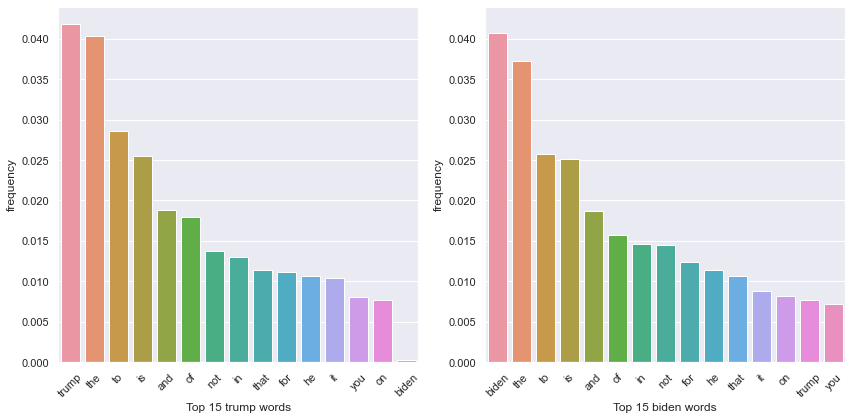


 stop_words: False, lemmatization: False, negation: True


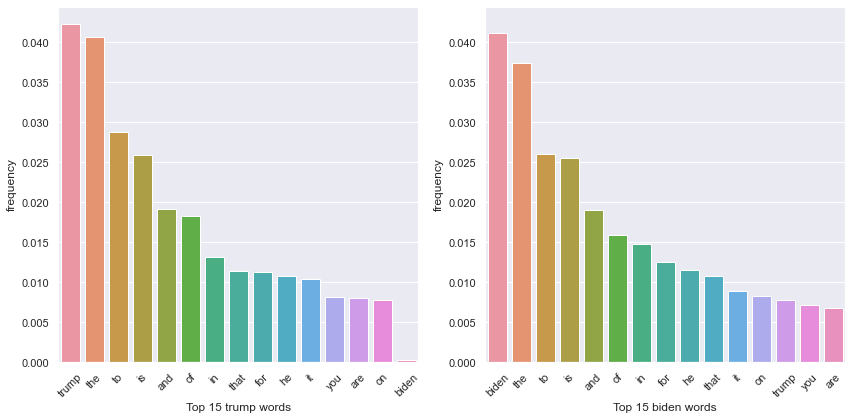


 stop_words: False, lemmatization: True, negation: False


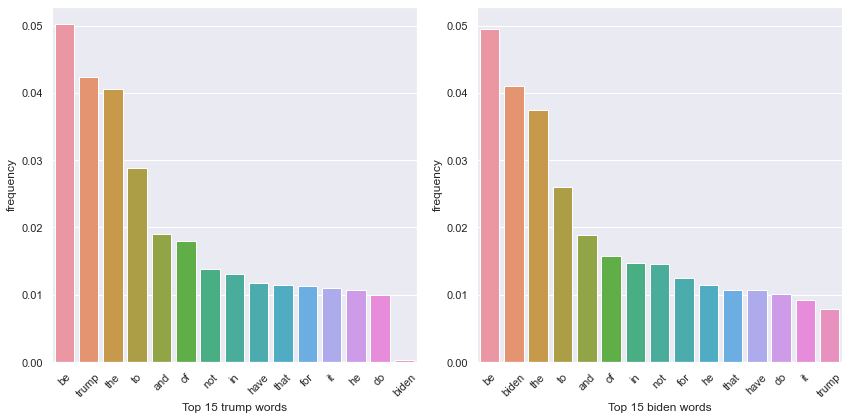


 stop_words: False, lemmatization: True, negation: True


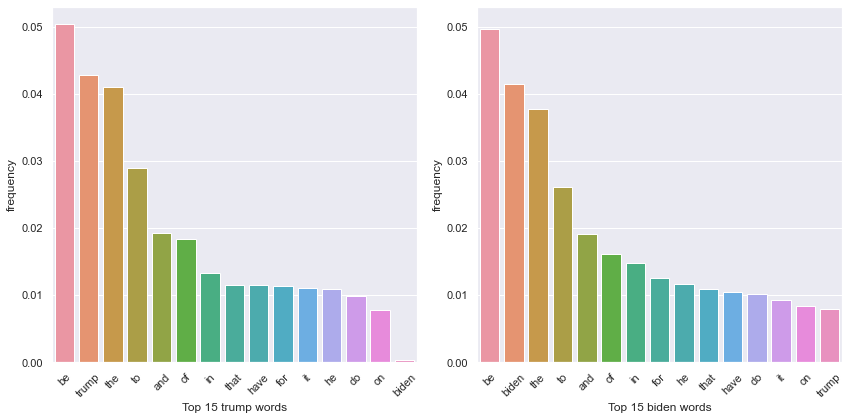


 stop_words: True, lemmatization: False, negation: False


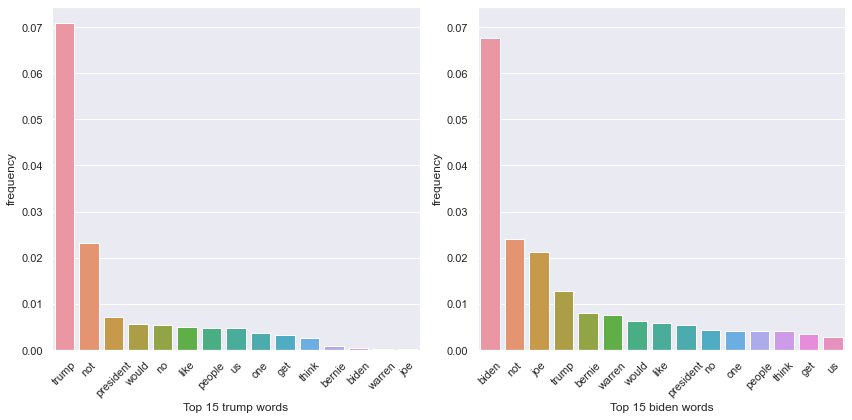


 stop_words: True, lemmatization: False, negation: True


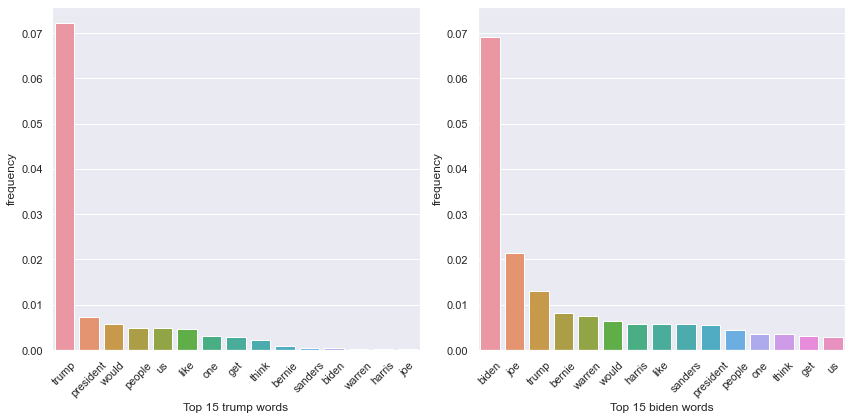


 stop_words: True, lemmatization: True, negation: False


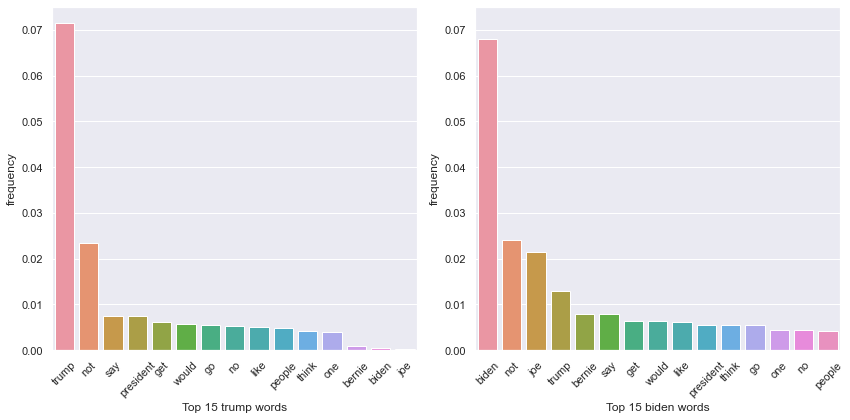


 stop_words: True, lemmatization: True, negation: True


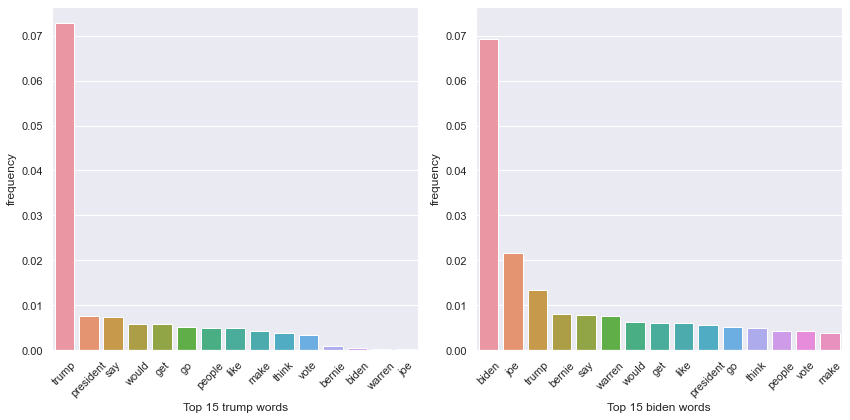

In [21]:
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            df_temp = tweets_web(stop_words, lemmatization, negation)
            print(f"\n stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            term_frequency(df_temp, 'search', 15)   

## 2.2 Corrélations

In [22]:
STOP_WORDS = True
LEMMATIZATION = True
NEGATION = False
df = tweets_web(STOP_WORDS, LEMMATIZATION, NEGATION)
df['trump_bool'] = (df['search'] == 'trump').astype(int)
df.head(10)

,search,author,time,url,text,lang,reply,trump_bool
0,biden,Maggie Klaus 🤶🏻,2019-01-01 22:37:46,/Maggie_Klaus/status/1080231636334067712,shut f ck hillary likability spew shit like gi...,en,False,0
1,biden,The Salt Lake Tribune,2019-01-01 22:15:18,/sltrib/status/1080225983083487232,agree pay former vice president speak campus l...,en,False,0
2,biden,The New York Times,2019-01-01 20:00:08,/nytimes/status/1080191967873716224,series careful financial decision creation non...,en,False,0
3,biden,Matt Binder,2019-01-01 22:18:51,/MattBinder/status/1080226876226965504,agree useful democrat definitely not vote joe ...,en,False,0
4,biden,Patrick Healy,2019-01-01 19:58:58,/patrickhealynyt/status/1080191673701933059,news joe biden campaign wait include longtime ...,en,False,0
5,biden,Ashton Pittman,2019-01-01 23:52:34,/ashtonpittman/status/1080250459200344065,also fox news newt gingrich praise sen marco r...,en,False,0
6,biden,Ashton Pittman,2019-01-01 23:52:35,/ashtonpittman/status/1080250465718288384,republican fox news even high praise vice pres...,en,False,0
7,biden,Virgil Xmas 🎄🎁💸,2019-01-01 22:25:54,/virgiltexas/status/1080228651327733760,every joe biden vote go not vote ten,en,False,0
8,biden,Katelyn Burns,2019-01-01 22:01:53,/transscribe/status/1080222604668166144,unspoken untrue premise piece people like bide...,en,False,0
9,biden,Susan Murphy,2019-01-01 22:59:08,/susmurphy/status/1080237012689530883,dem race vote whoever nom give really not want...,en,False,0


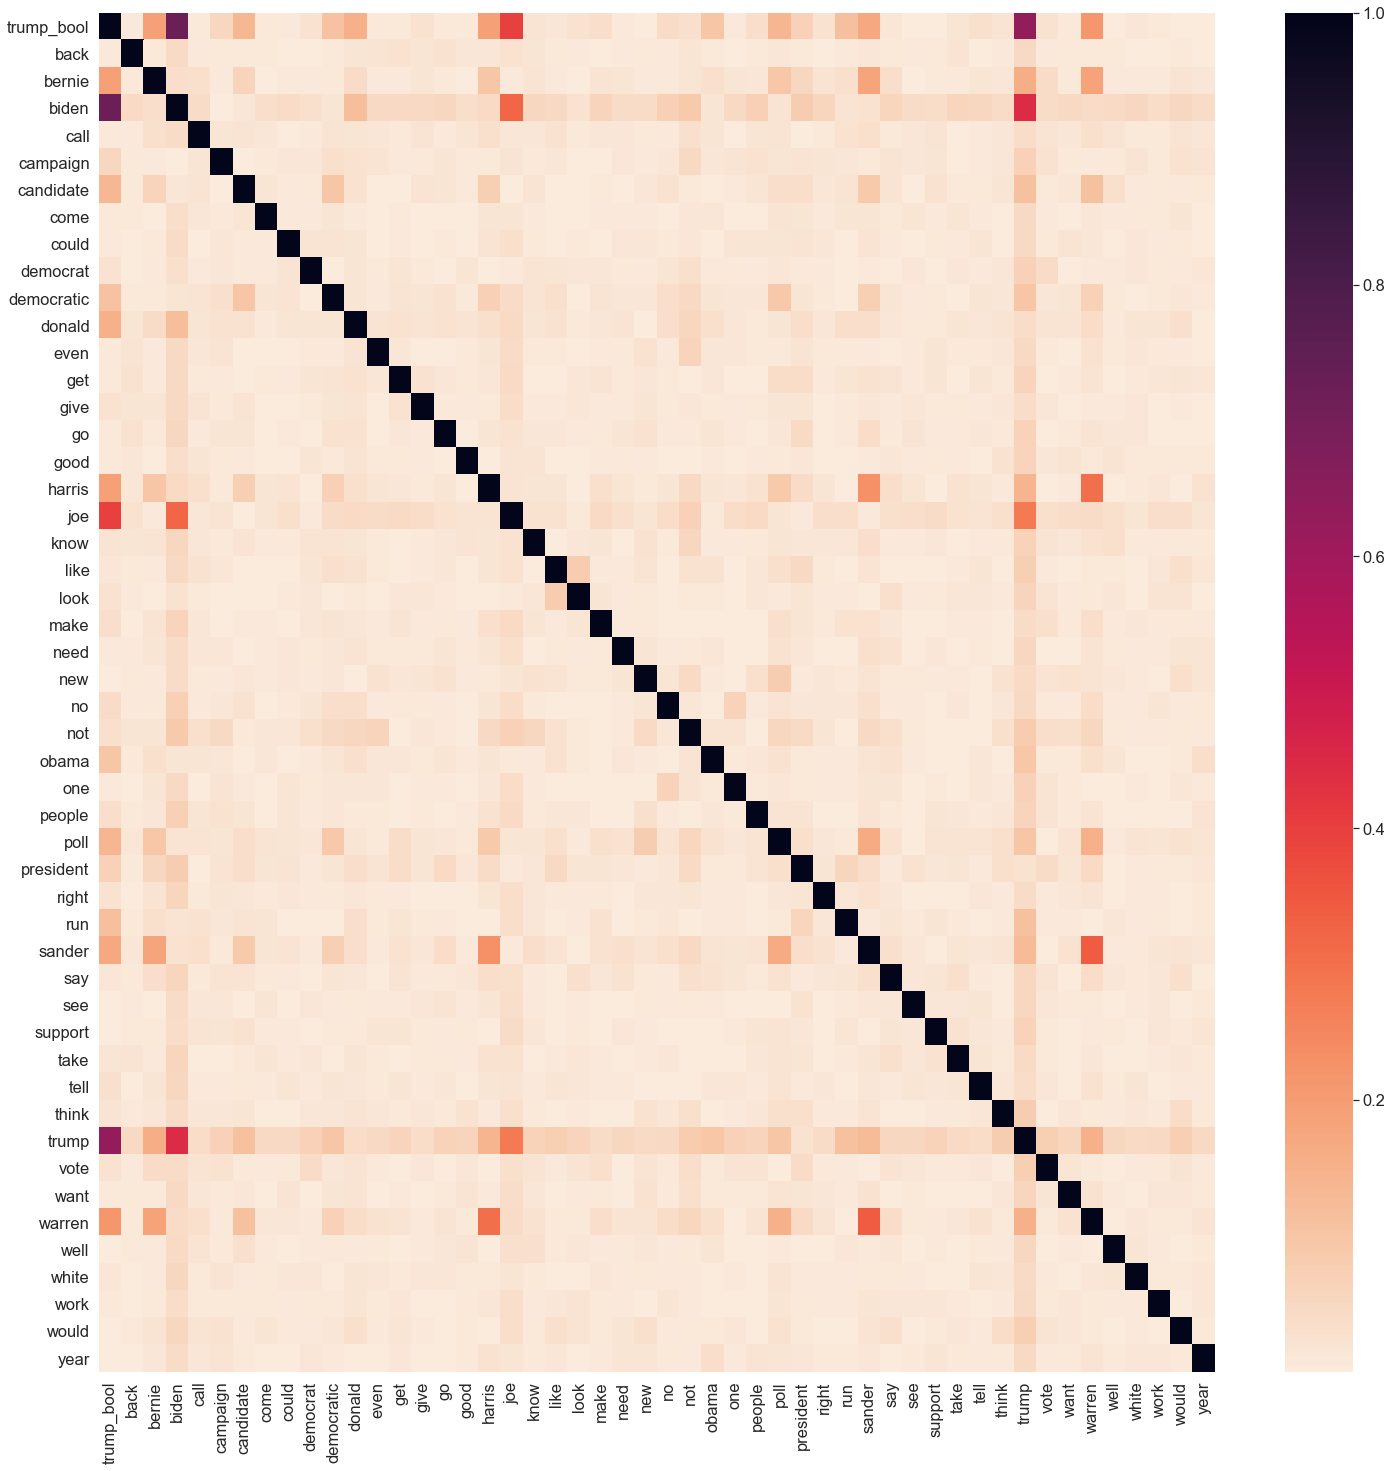

Wall time: 1.3 s


In [23]:
%%time
corr_matrix(df, 50, TfidfVectorizer)

In [24]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:10:35
